# Ultrafast Shape Recognition (USR) Descriptor — MUV Dataset

This notebook implements the **Ultrafast Shape Recognition (USR)** descriptor to evaluate ligand-decoy separability on the **MUV** dataset.

We:
1. Compute 3D shape descriptors from ligand and decoy point clouds.
2. Train multiple ML models (**Logistic Regression**, **Random Forest**, **SVM**, **XGBoost**).
3. Evaluate model performance using **AUC** and **Enrichment Factor (EF%)**.
4. Compare results across all MUV targets.

In [1]:
import os
import numpy as np
from scipy.stats import skew
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
# Define the path to the extracted directory
targets_dir = r'C:\Users\kanis\Desktop\Python\Computational Geometry and Topology for Drug Discovery\MUV\MUV_5D_PointClouds_7April2025\MUV_5D_PointClouds'

# List and sort the contents (targets)
targets = sorted(os.listdir(targets_dir))
print("Targets found:", targets)


Targets found: ['466', '548', '600', '644', '652', '689', '692', '712', '713', '733', '737', '810', '832', '846', '852', '858', '859']


## 1. Dataset Loading and Exploration

The **MUV dataset** provides unbiased benchmark targets for virtual screening and ligand discovery tasks.

Each target directory contains:
- `ligs/` → Active ligands  
- `decoys/` → Inactive decoy molecules  

We verify that all targets are available and count ligands/decoys.


In [2]:
ligands = os.listdir(os.path.join(targets_dir, "846", "ligs"))
decoys = os.listdir(os.path.join(targets_dir, "846", "decoys"))

print(f"Number of ligands: {len(ligands)}")
print(f"Number of decoys: {len(decoys)}")


Number of ligands: 30
Number of decoys: 15000


## 2. Computing USR Descriptors

The USR descriptor encodes molecular shape using four reference points:
1. **Centroid (CTD)** — molecular center of mass  
2. **Closest Atom (CST)** — nearest to centroid  
3. **Farthest Atom (FCT)** — farthest from centroid  
4. **Farthest from FCT (FTF)** — maximally distant atom

For each point, three statistical measures are calculated:
- Mean distance  
- Standard deviation  
- Cubic root of skewness  

This yields a **12-dimensional descriptor** per molecule.


In [3]:
def usr_descriptors(atom_positions):
    centroid = np.mean(atom_positions, axis=0)
    d_ctd = np.linalg.norm(atom_positions - centroid, axis=1)
    cst = atom_positions[np.argmin(d_ctd)]
    fct = atom_positions[np.argmax(d_ctd)]
    d_fct = np.linalg.norm(atom_positions - fct, axis=1)
    ftf = atom_positions[np.argmax(d_fct)]
    points = [centroid, cst, fct, ftf]
    descriptors = []
    for point in points:
        distances = np.linalg.norm(atom_positions - point, axis=1)
        descriptors.extend([np.mean(distances), np.std(distances), np.cbrt(skew(distances))])
    return descriptors

def generate_usr_features(file_list, directory, label):
    data = []
    for file in file_list:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path, header=None)
        atom_positions = df.iloc[:, :3].values
        features = usr_descriptors(atom_positions)
        features.append(label)
        data.append(features)
    cols = [f'usr_{i+1}' for i in range(12)] + ['label']
    return pd.DataFrame(data, columns=cols)


## 3. Enrichment Factor (EF%) Calculation

The **Enrichment Factor** quantifies how effectively the model ranks true actives near the top of predictions.

It compares the hit rate within the top 30 % of ranked molecules to the expected hit rate under random selection.


In [4]:
def enrichment_factor(y_true, y_probs, top_percent=30):
    N = len(y_true)
    top_n = int(N * (top_percent / 100))
    sorted_idx = np.argsort(y_probs)[::-1][:top_n]
    hits = np.sum(np.array(y_true)[sorted_idx])
    total_actives = np.sum(y_true)
    ef = (hits / top_n) / (total_actives / N)
    return ef


## 4. Model Training and Evaluation

We evaluate four classifiers per target:
- Logistic Regression  
- Random Forest  
- SVM (RBF Kernel)  
- XGBoost  

Each model is trained on balanced ligand-decoy splits (80/20 train-test),  
and evaluated using:
- **AUC (Area Under ROC Curve)**  
- **Enrichment Factor (EF%)**, measuring early retrieval of actives.



 Target: 466


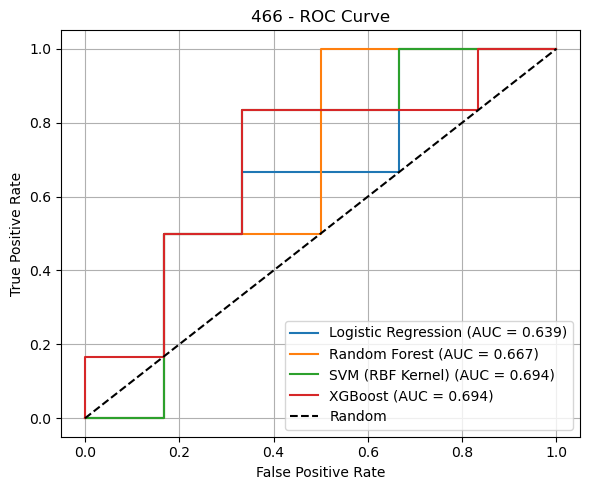


 Target: 548


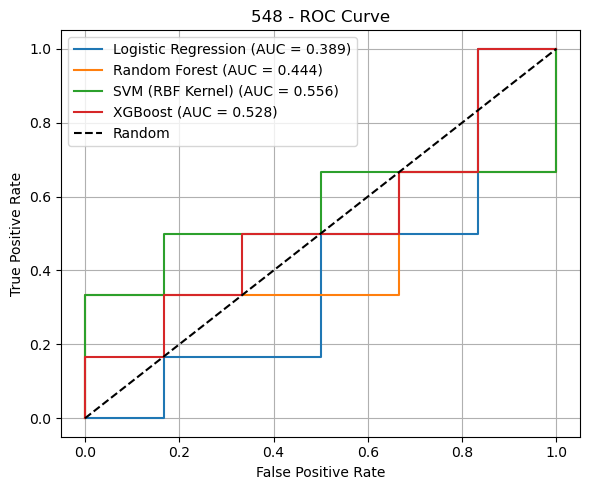


 Target: 600


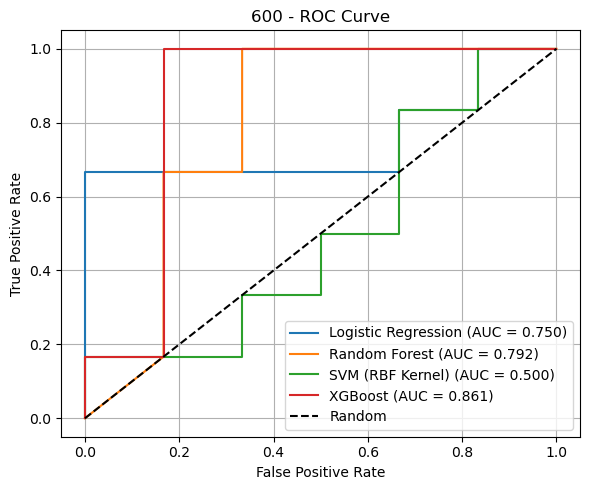


 Target: 644


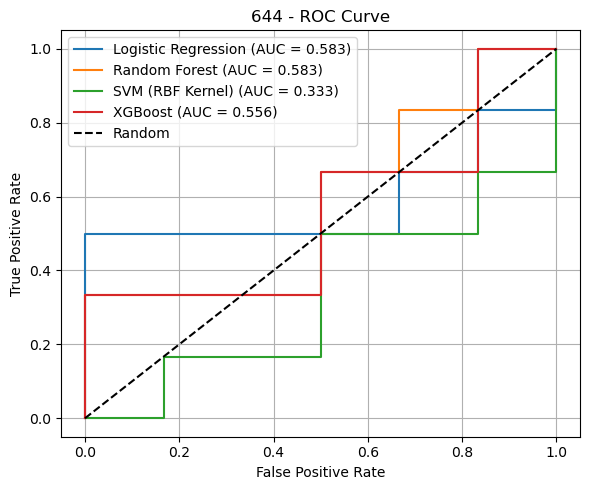


 Target: 652


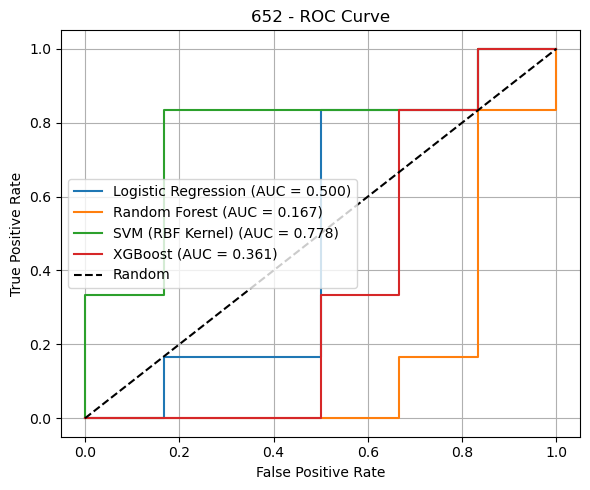


 Target: 689


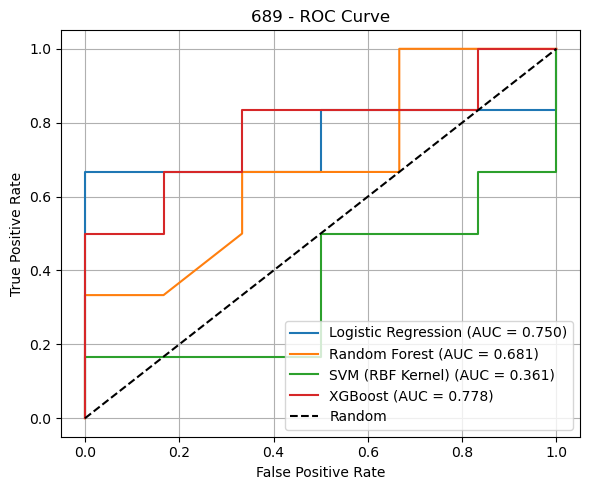


 Target: 692


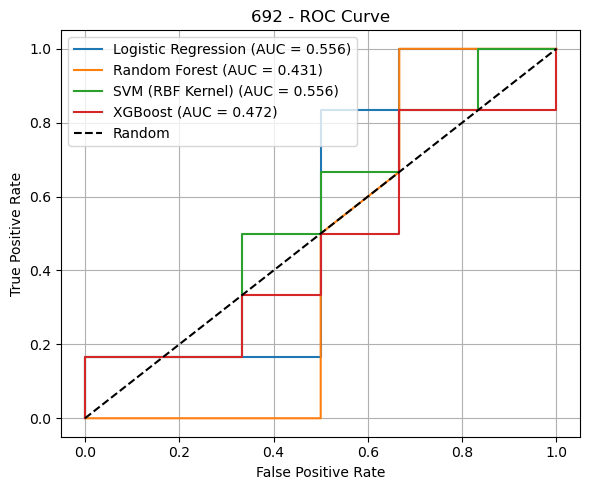


 Target: 712


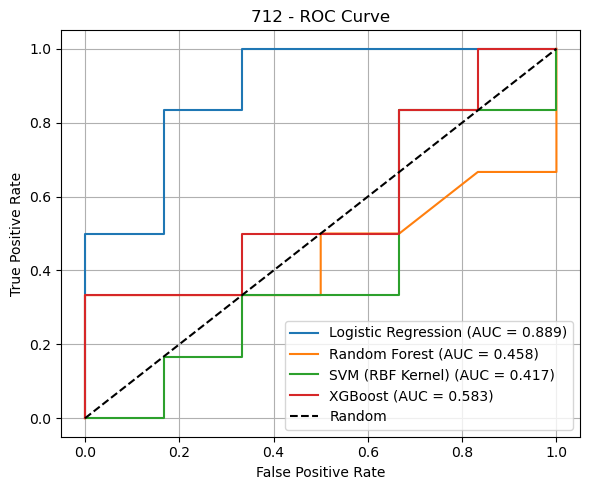


 Target: 713


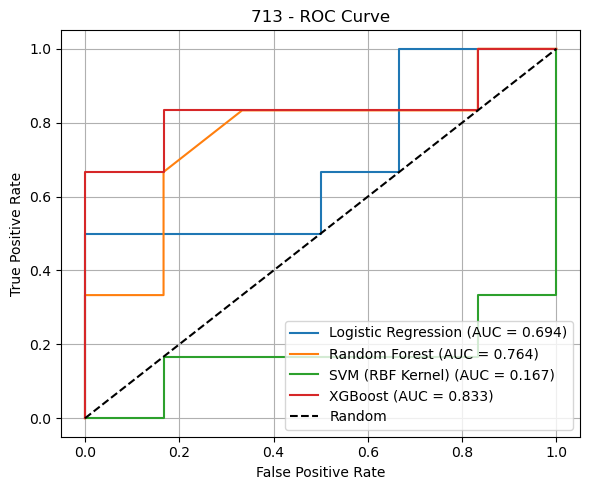


 Target: 733


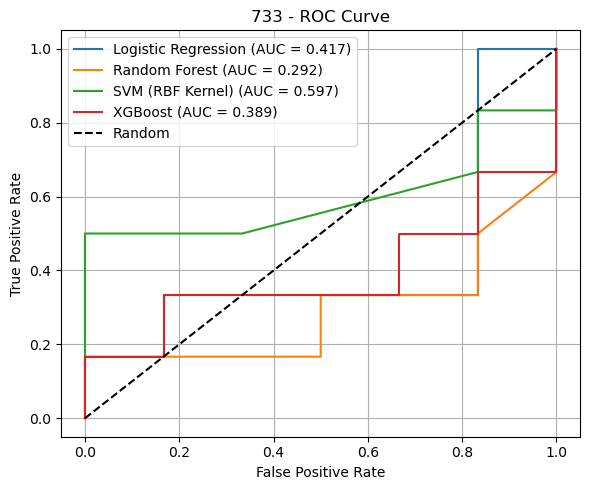


 Target: 737


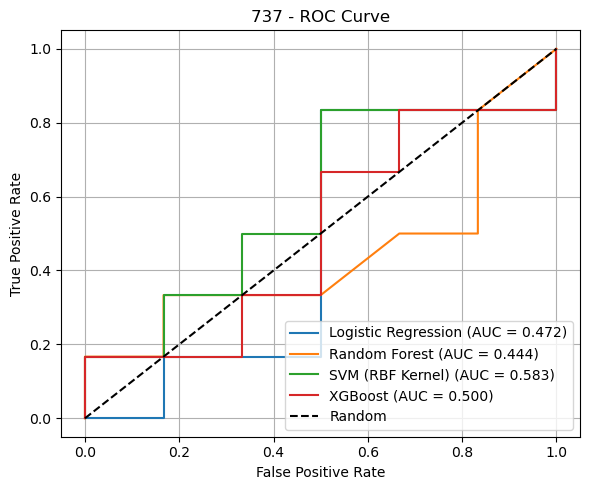


 Target: 810


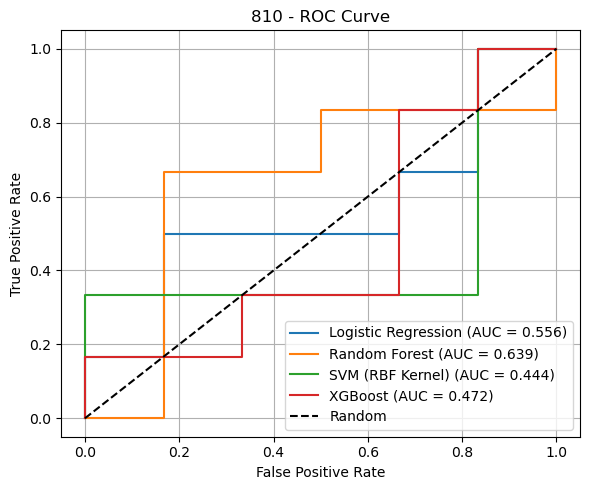


 Target: 832


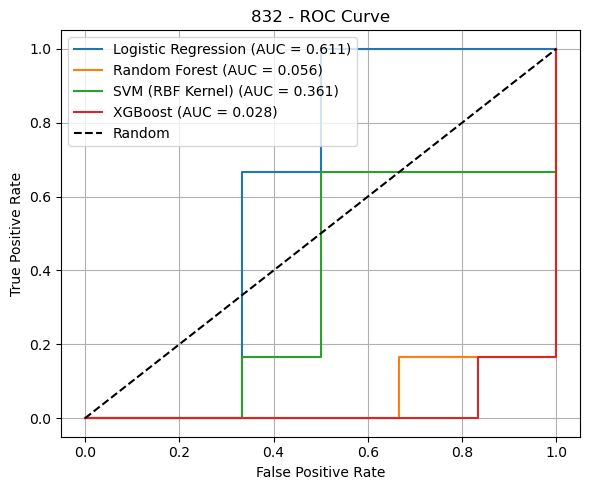


 Target: 846


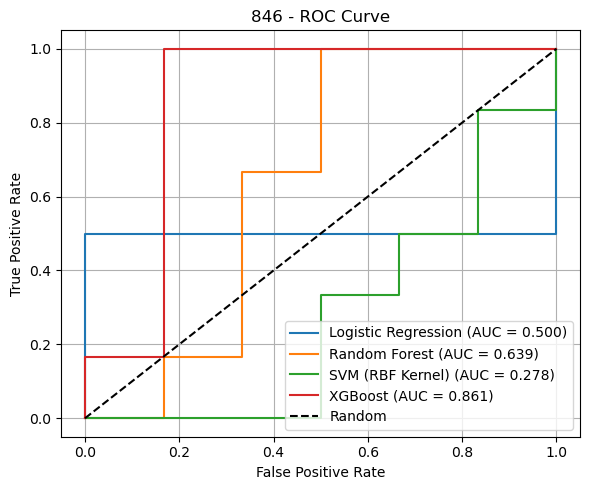


 Target: 852


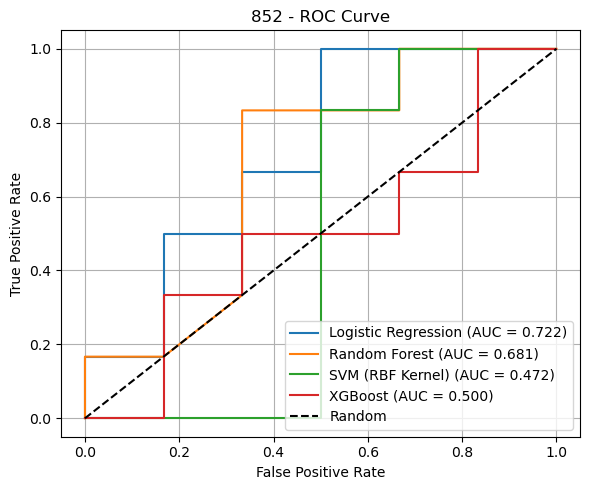


 Target: 858


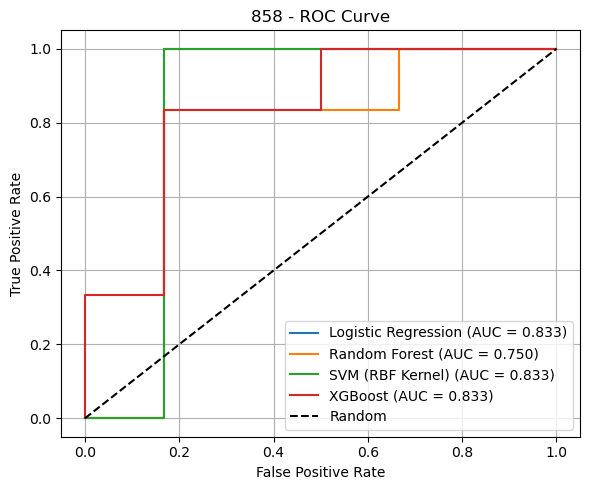


 Target: 859


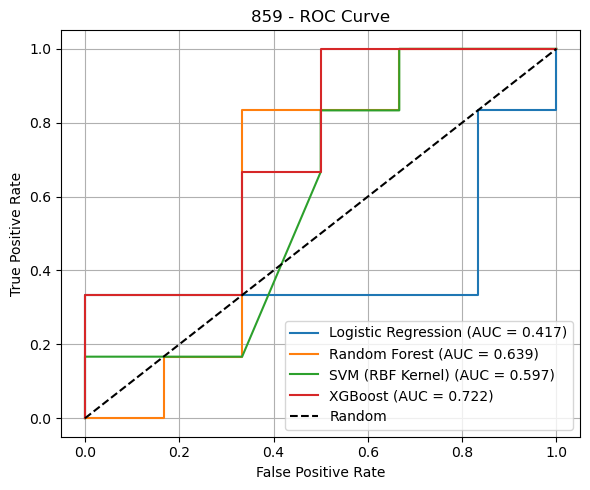

In [5]:
all_muv_results = {}

for target in targets:
    print(f"\n Target: {target}")
    lig_dir = os.path.join(targets_dir, target, 'ligs')
    decoy_dir = os.path.join(targets_dir, target, 'decoys')

    lig_files = os.listdir(lig_dir)
    decoy_files = os.listdir(decoy_dir)

    # Train-test split
    train_lig, test_lig = train_test_split(lig_files, test_size=0.2, random_state=42)
    train_dec, test_dec = train_test_split(decoy_files, test_size=0.2, random_state=42)

    # Balance decoys
    train_dec = resample(train_dec, replace=False, n_samples=len(train_lig), random_state=42)
    test_dec = resample(test_dec, replace=False, n_samples=len(test_lig), random_state=42)

    # Generate features
    train_lig_df = generate_usr_features(train_lig, lig_dir, 1)
    train_dec_df = generate_usr_features(train_dec, decoy_dir, 0)
    test_lig_df = generate_usr_features(test_lig, lig_dir, 1)
    test_dec_df = generate_usr_features(test_dec, decoy_dir, 0)

    train_df = pd.concat([train_lig_df, train_dec_df]).sample(frac=1, random_state=42)
    test_df = pd.concat([test_lig_df, test_dec_df]).sample(frac=1, random_state=42)

    X_train = train_df.drop("label", axis=1)
    y_train = train_df["label"]
    X_test = test_df.drop("label", axis=1)
    y_test = test_df["label"]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "SVM (RBF Kernel)": SVC(probability=True),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    }

    model_results = []
    plt.figure(figsize=(6, 5))

    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        probs = model.predict_proba(X_test_scaled)[:, 1]
        auc = roc_auc_score(y_test, probs)
        ef = enrichment_factor(y_test, probs, top_percent=30)

        fpr, tpr, _ = roc_curve(y_test, probs)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.3f})")

        model_results.append({
            'Model': model_name,
            'AUC': round(auc, 4),
            'EF%': round(ef, 3)
        })

    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.title(f"{target} - ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    result_df = pd.DataFrame(model_results)
    all_muv_results[target] = result_df


In [6]:
for target, df in all_muv_results.items():
    print(f"\n Results for {target}")
    display(df)



 Results for 466


,Model,AUC,EF%
0,Logistic Regression,0.6389,1.333
1,Random Forest,0.6667,1.333
2,SVM (RBF Kernel),0.6944,1.333
3,XGBoost,0.6944,1.333



 Results for 548


,Model,AUC,EF%
0,Logistic Regression,0.3889,0.667
1,Random Forest,0.4444,1.333
2,SVM (RBF Kernel),0.5556,1.333
3,XGBoost,0.5278,1.333



 Results for 600


,Model,AUC,EF%
0,Logistic Regression,0.7500,2.000
1,Random Forest,0.7917,1.333
2,SVM (RBF Kernel),0.5000,0.667
3,XGBoost,0.8611,1.333



 Results for 644


,Model,AUC,EF%
0,Logistic Regression,0.5833,2.000
1,Random Forest,0.5833,1.333
2,SVM (RBF Kernel),0.3333,0.667
3,XGBoost,0.5556,1.333



 Results for 652


,Model,AUC,EF%
0,Logistic Regression,0.5000,0.667
1,Random Forest,0.1667,0.000
2,SVM (RBF Kernel),0.7778,1.333
3,XGBoost,0.3611,0.000



 Results for 689


,Model,AUC,EF%
0,Logistic Regression,0.7500,2.000
1,Random Forest,0.6806,1.333
2,SVM (RBF Kernel),0.3611,0.667
3,XGBoost,0.7778,2.000



 Results for 692


,Model,AUC,EF%
0,Logistic Regression,0.5556,0.667
1,Random Forest,0.4306,0.000
2,SVM (RBF Kernel),0.5556,0.667
3,XGBoost,0.4722,0.667



 Results for 712


,Model,AUC,EF%
0,Logistic Regression,0.8889,2.000
1,Random Forest,0.4583,1.333
2,SVM (RBF Kernel),0.4167,0.667
3,XGBoost,0.5833,1.333



 Results for 713


,Model,AUC,EF%
0,Logistic Regression,0.6944,2.000
1,Random Forest,0.7639,1.333
2,SVM (RBF Kernel),0.1667,0.667
3,XGBoost,0.8333,2.000



 Results for 733


,Model,AUC,EF%
0,Logistic Regression,0.4167,1.333
1,Random Forest,0.2917,0.667
2,SVM (RBF Kernel),0.5972,2.000
3,XGBoost,0.3889,1.333



 Results for 737


,Model,AUC,EF%
0,Logistic Regression,0.4722,0.667
1,Random Forest,0.4444,1.333
2,SVM (RBF Kernel),0.5833,1.333
3,XGBoost,0.5000,0.667



 Results for 810


,Model,AUC,EF%
0,Logistic Regression,0.5556,1.333
1,Random Forest,0.6389,1.333
2,SVM (RBF Kernel),0.4444,1.333
3,XGBoost,0.4722,0.667



 Results for 832


,Model,AUC,EF%
0,Logistic Regression,0.6111,0.667
1,Random Forest,0.0556,0.000
2,SVM (RBF Kernel),0.3611,0.667
3,XGBoost,0.0278,0.000



 Results for 846


,Model,AUC,EF%
0,Logistic Regression,0.5000,2.000
1,Random Forest,0.6389,0.667
2,SVM (RBF Kernel),0.2778,0.000
3,XGBoost,0.8611,1.333



 Results for 852


,Model,AUC,EF%
0,Logistic Regression,0.7222,1.333
1,Random Forest,0.6806,1.333
2,SVM (RBF Kernel),0.4722,0.000
3,XGBoost,0.5000,1.333



 Results for 858


,Model,AUC,EF%
0,Logistic Regression,0.8333,1.333
1,Random Forest,0.7500,1.333
2,SVM (RBF Kernel),0.8333,1.333
3,XGBoost,0.8333,1.333



 Results for 859


,Model,AUC,EF%
0,Logistic Regression,0.4167,1.333
1,Random Forest,0.6389,0.667
2,SVM (RBF Kernel),0.5972,0.667
3,XGBoost,0.7222,1.333


## 5. Results Summary — USR Descriptor (MUV)

| Metric | Mean ± SD |
|---------|------------|
| **AUC** | 0.58 ± 0.058 |
| **EF%** | 1.13 ± 0.092 |

### Key Observations
- The USR descriptor shows weak performance on the more challenging MUV dataset, with an AUC just above random.
- This highlights USR's limitations in handling datasets with higher class imbalance and more complex decoys.
- It serves as a critical baseline, demonstrating the significant performance lift provided by the more advanced topological descriptors.